# Long Short-Term Memory (LSTM)

Stock Market Predictions with LSTM in Python

Source: https://www.datacamp.com/tutorial/lstm-python-stock-market

In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas_datareader 

  Using cached pandas_datareader-0.10.0-py3-none-any.whl.metadata (2.9 kB)
Using cached pandas_datareader-0.10.0-py3-none-any.whl (109 kB)
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install yfinance

In [39]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import os
import yfinance as yf
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [26]:
stock_ticker = yf.Ticker("CIB")
data_history = stock_ticker.history(period="20y")
print(data_history)

                                Open       High        Low      Close  Volume  \
Date                                                                            
2005-03-21 00:00:00-05:00   6.472285   6.472285   5.887119   6.246198  352800   
2005-03-22 00:00:00-05:00   6.250629   6.365889   5.851652   5.940314  268300   
2005-03-23 00:00:00-05:00   5.876614   5.934931   5.773436   5.800352  293300   
2005-03-24 00:00:00-05:00   5.800353   6.100913   5.800353   6.051567  137800   
2005-03-28 00:00:00-05:00   5.831753   6.087453   5.831753   5.876613  168100   
...                              ...        ...        ...        ...     ...   
2025-03-13 00:00:00-04:00  42.139999  42.669998  41.450001  41.570000  318000   
2025-03-14 00:00:00-04:00  42.250000  43.290001  41.770000  43.119999  325900   
2025-03-17 00:00:00-04:00  43.169998  43.970001  43.169998  43.889999  285200   
2025-03-18 00:00:00-04:00  44.029999  44.029999  42.919998  43.080002  380200   
2025-03-19 00:00:00-04:00  4

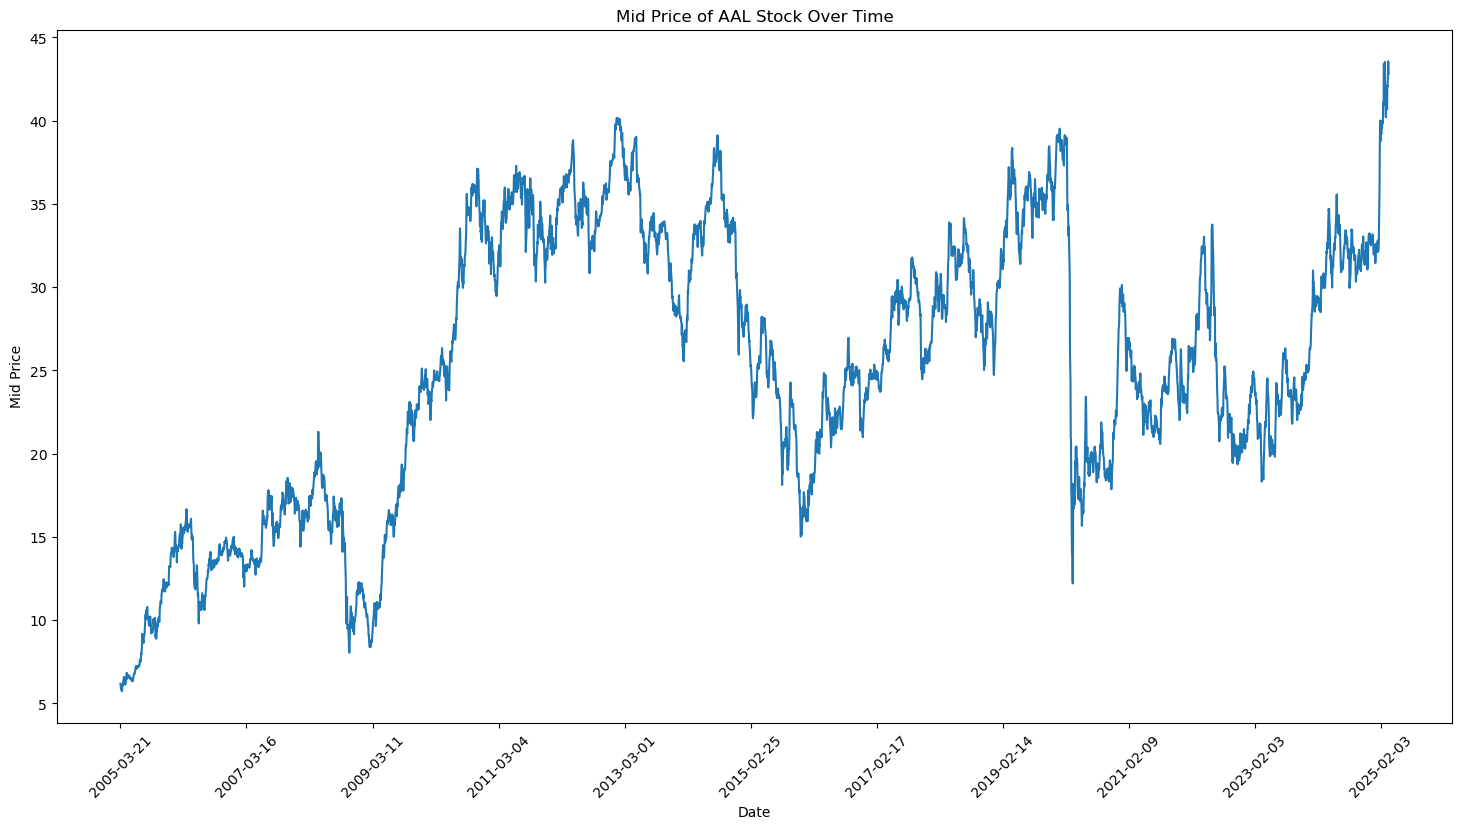

In [28]:
# Create a figure for plotting
plt.figure(figsize=(18, 9))

# Plot the mid price
plt.plot(range(data_history.shape[0]), (data_history['Low'] + data_history['High']) / 2.0)

# Set x-ticks using the index (dates)
plt.xticks(range(0, data_history.shape[0], 500), data_history.index[::500].date, rotation=45)

# Label the axes
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.title('Mid Price of AAL Stock Over Time')
plt.show()

# Splitting Data Into a Training Set and a Test Set

You will use the mid-price, which is calculated by taking the average of the highest and lowest recorded prices on a day.

In [31]:
# Extract high and low prices using .loc
high_prices = data_history.loc[:, 'High'].to_numpy()  # Use .to_numpy() instead of .as_matrix()
low_prices = data_history.loc[:, 'Low'].to_numpy()

# Calculate mid prices
mid_prices = (high_prices + low_prices) / 2.0

In [33]:
# The training data will be the first 11,000 data points of the time series, and the rest will be test data.
train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

In [35]:
# Normalizing the Data
# MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape [data_size, num_features]
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [41]:
# Adjust the loop to avoid going out of bounds
smoothing_window_size = 2500
num_chunks = len(train_data) // smoothing_window_size

for di in range(num_chunks):
    start_index = di * smoothing_window_size
    end_index = start_index + smoothing_window_size
    scaler.fit(train_data[start_index:end_index, :])
    train_data[start_index:end_index, :] = scaler.transform(train_data[start_index:end_index, :])

# Normalize the last bit of remaining data if there are any left
remaining_start_index = num_chunks * smoothing_window_size
if remaining_start_index < len(train_data):
    scaler.fit(train_data[remaining_start_index:, :])
    train_data[remaining_start_index:, :] = scaler.transform(train_data[remaining_start_index:, :])

In [45]:
# Reshape both train and test data
train_data = train_data.reshape(-1, 1)  # Ensure it's 2D for the scaler

# Check the shape of test_data before transforming
print("Shape of test_data before transformation:", test_data.shape)

# Normalize the test data only if it has samples
if test_data.size > 0:
    test_data = test_data.reshape(-1, 1)  # Ensure it's 2D for the scaler
    test_data = scaler.transform(test_data).reshape(-1)
else:
    print("test_data is empty, cannot transform.")

Shape of test_data before transformation: (0, 1)
test_data is empty, cannot transform.


In [49]:
# Check the size of train_data
print("Size of train_data:", train_data.shape)

# Perform exponential moving average smoothing
EMA = 0.0
gamma = 0.1

# Use the actual size of train_data for the loop
for ti in range(train_data.shape[0]):  # Use the size of train_data
    EMA = gamma * train_data[ti] + (1 - gamma) * EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data, test_data], axis=0)

Size of train_data: (5032, 1)


In [53]:
# Assuming data_history is your DataFrame with stock data
df = data_history.reset_index()  # Create df with 'Date' column

window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size, N):
    if pred_idx >= N:
        # If pred_idx exceeds N, you might want to handle this case differently
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx, 'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx - window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f' % (0.5 * np.mean(mse_errors)))

MSE error for standard averaging: 0.00416


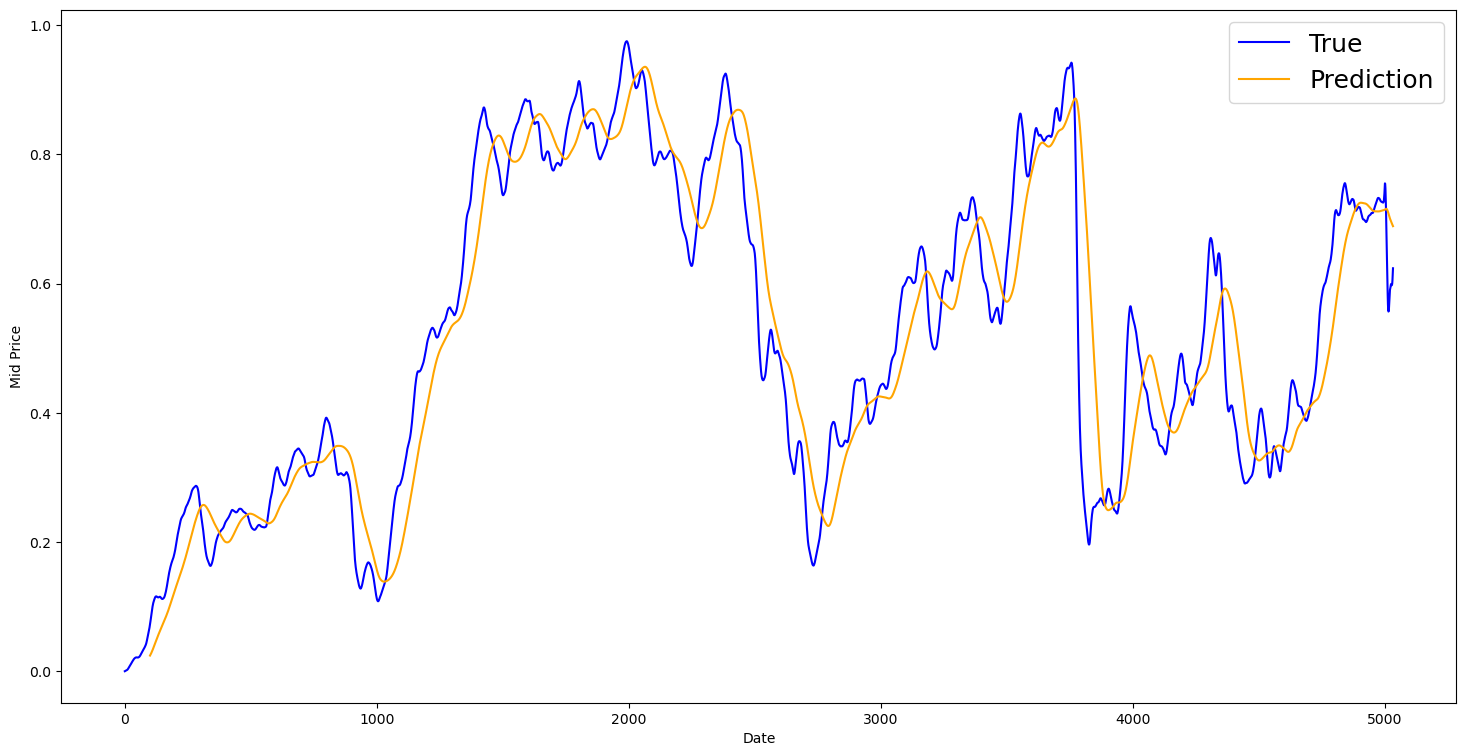

In [55]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [57]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00002


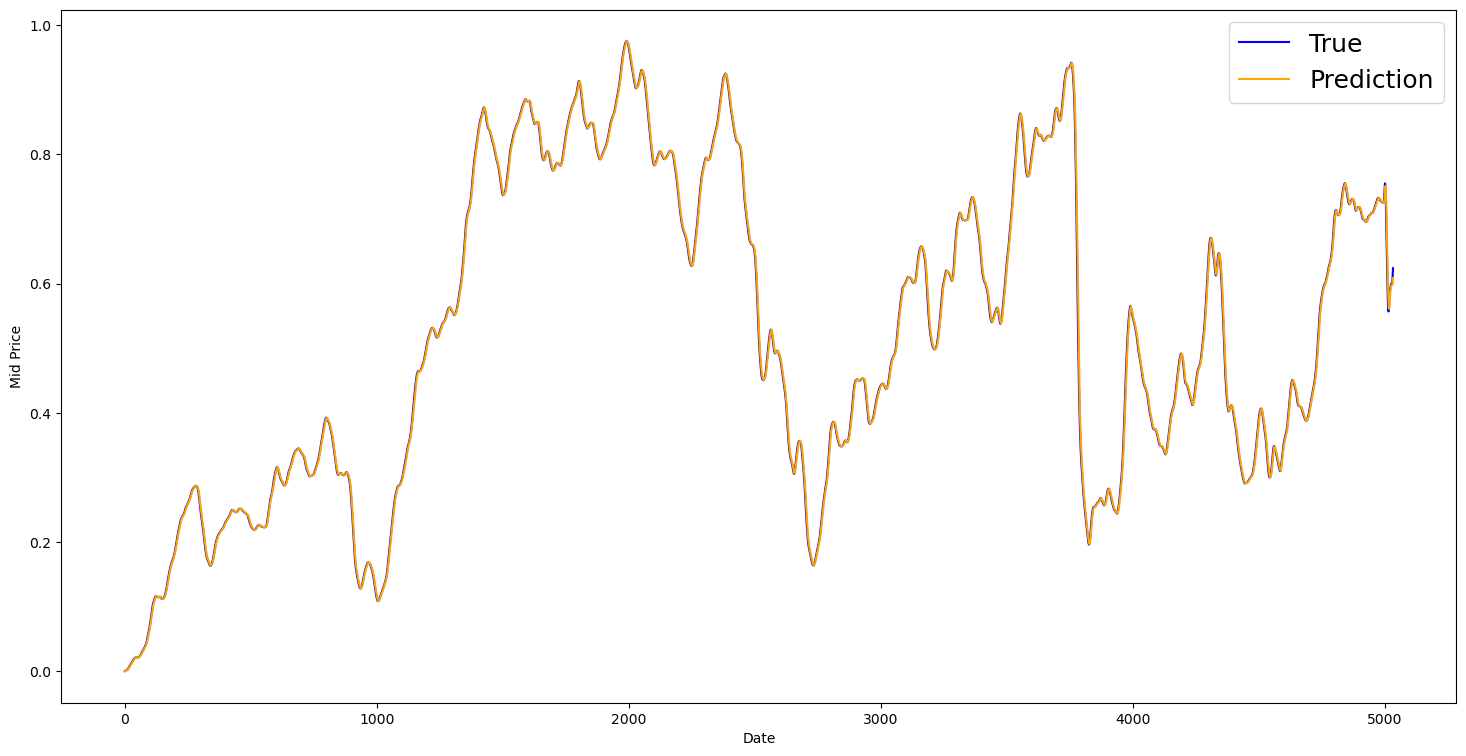

In [69]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [ ]:
#Introduction to LSTMs: Making Stock Movement Predictions Far into the Future